In [1]:
import os

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch
from tqdm.auto import tqdm
import xarray as xr

from fair import FAIR
from fair.io import read_properties
from fair.interface import initialise, fill

In [2]:
n_ens = 1001

In [3]:
pd.options.display.max_columns = 50
df_configs = pd.read_csv('../data/calibrated_constrained_parameters_v1.1.0.csv', index_col=0)
valid_all = df_configs.index
df_configs

,gamma,c1,c2,c3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,F_4xCO2,r0,rU,rT,rA,ari BC,ari CH4,ari N2O,ari NH3,ari NOx,ari OC,ari Sulfur,ari VOC,ari Equivalent effective stratospheric chlorine,shape Sulfur,shape BC,shape OC,beta,o3 CH4,o3 N2O,o3 Equivalent effective stratospheric chlorine,o3 CO,o3 VOC,o3 NOx,scale CH4,scale N2O,scale minorGHG,scale Stratospheric water vapour,scale Contrails,scale Light absorbing particles on snow and ice,scale Land use,scale Volcanic,solar_amplitude,solar_trend,scale CO2,co2_concentration_1750,seed
223,2.542893,4.427776,6.439976,27.811738,1.520582,2.611941,0.791147,1.785763,0.019479,0.224300,6.348804,31.936510,0.002626,2.055066,0.003369,0.008822,-3.451252e-06,-0.000024,-0.001067,-0.000047,-0.000672,-0.001923,-0.000018,-1.132060e-05,0.022977,0.349349,0.123125,-0.729603,0.000168,0.001289,-0.000137,0.000027,-0.000264,0.000909,0.879487,1.078154,0.997515,0.108490,2.909226,1.968794,1.153243,1.174896,1.150642,0.074411,1.113938,280.996949,1444740
248,2.699183,5.652514,12.693147,96.305433,1.451888,2.190332,1.587625,1.503535,0.634219,0.407836,6.491680,29.324706,0.006695,4.691437,-0.000974,0.036846,-3.257414e-07,-0.000066,-0.000891,-0.000055,-0.006301,-0.005698,-0.000011,-1.083569e-05,0.021982,0.247860,0.078642,-0.177567,0.000285,0.000358,-0.000080,0.000020,-0.000023,0.001222,1.125038,0.917635,1.023205,1.120879,1.301683,1.608106,1.257000,1.114128,1.235605,-0.043372,1.103832,279.272092,1454715
337,5.560834,4.520785,29.034908,31.431180,1.140293,2.933847,1.202307,1.639030,0.757088,0.525296,5.578908,32.653469,0.003120,0.214407,0.004500,0.002526,-3.291138e-06,-0.000024,-0.000131,-0.000016,-0.003251,-0.000960,-0.000026,-9.196405e-07,0.017118,0.373225,0.006599,-0.960850,0.000254,0.000772,-0.000200,0.000218,0.000076,0.001981,0.857112,1.048651,1.009053,0.361334,0.788912,0.290387,1.168830,1.044172,0.944002,0.059474,1.168394,280.221119,1490226
1126,9.119766,4.038270,10.507803,136.797996,0.901322,2.853364,1.180568,1.633855,0.842745,0.469932,7.568183,38.815261,-0.002492,-0.108030,0.004830,0.002485,-4.225179e-06,-0.000009,-0.000868,-0.000065,-0.004499,-0.005141,-0.000028,-1.316266e-05,0.028669,0.298072,0.062526,-0.831610,0.000209,0.001504,0.000010,0.000056,0.000124,0.002468,0.869639,0.985324,0.915102,0.092992,1.323717,1.284205,0.765529,1.183536,0.698080,-0.006882,1.027689,276.774836,1805037
1483,1.541741,5.884384,10.171038,144.590161,1.324372,5.830341,0.986666,1.261385,0.493214,0.743539,8.270530,37.820453,-0.000269,1.940335,0.002673,0.018873,-1.980558e-06,-0.000013,-0.000500,-0.000038,-0.000862,-0.003133,-0.000028,-1.276174e-05,0.011799,0.076998,0.087125,-1.020549,0.000271,0.001157,-0.000174,0.000101,0.000014,0.001060,0.784100,1.097401,1.150912,1.774764,1.342722,0.741301,0.816963,0.851670,1.046927,0.011883,0.978011,275.662447,1947480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492261,4.968727,4.218896,9.667449,30.636191,0.736617,8.853330,0.935823,1.880711,0.837531,0.297188,7.719510,36.603462,0.000046,1.152309,0.003964,0.023440,-1.353779e-07,-0.000009,-0.000743,-0.000081,-0.004159,-0.004731,-0.000017,-5.993568e-06,0.050984,0.319571,0.229122,-0.744125,0.000214,0.001564,-0.000165,-0.000044,0.000282,0.000507,1.010105,1.001127,0.754262,1.756522,0.512282,0.191991,1.145589,1.227137,0.972447,-0.063055,1.016986,277.309390,596767902
1495153,1.322185,5.140556,10.609605,71.178776,1.137627,4.253920,2.038106,1.768273,0.511371,0.575900,9.370897,34.270269,0.000927,3.220787,0.002926,0.012356,-2.217950e-06,-0.000007,-0.000106,-0.000004,-0.003220,-0.001568,-0.000010,-5.151332e-06,0.031713,0.603191,0.010330,-0.558251,0.000288,0.000921,-0.000082,0.000173,-0.000221,0.001183,0.945883,1.080344,1.127912,0.546554,0.998386,1.431100,1.550799,0.707496,0.938940,0.010310,0.900180,279.193966,597921810
1496559,12.387113,2.281608,6.387238,158.919994,1.103254,6.109164,1.769013,1.829621,2.027779,0.51129

In [4]:
df_solar = pd.read_csv(
    "../data/solar_erf_timebounds.csv", index_col="year"
)
df_volcanic = pd.read_csv(
    "../data/volcanic_ERF_monthly_-950001-201912.csv"
)

In [5]:
volcanic_forcing = np.zeros(551)
for i, year in enumerate(np.arange(1750, 2021)):
    volcanic_forcing[i] = np.mean(
        df_volcanic.loc[
            ((year - 1) <= df_volcanic["year"]) & (df_volcanic["year"] < year)
        ].erf
    )
volcanic_forcing[271:281] = np.linspace(1, 0, 10) * volcanic_forcing[270]

In [6]:
solar_forcing=np.zeros(551)
solar_forcing[:281] = df_solar['erf'].values[:281]
solar_forcing[271:281] = np.linspace(1, 0, 10) * solar_forcing[271:281]

In [7]:
trend_shape = np.ones(551)
trend_shape[:271] = np.linspace(0, 1, 271)

In [8]:
df_methane = pd.read_csv(
    "../data/CH4_lifetime.csv",
    index_col=0,
)

In [9]:
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2300, 1)
scenarios = ['ssp119', 'ssp534-over', 'ssp585']
f.define_scenarios(scenarios)
species, properties = read_properties()
f.define_species(species, properties)
f.define_configs(list(valid_all))
f.allocate()

In [10]:
f.fill_from_rcmip()

In [11]:
# solar and volcanic forcing
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs.loc[valid_all, "scale Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs.loc[valid_all, "solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs.loc[valid_all, "solar_trend"].values.squeeze(),
    specie="Solar",
)

# climate response
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[valid_all, "c1":"c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[valid_all, "kappa1":"kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs.loc[valid_all,"epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs.loc[valid_all,"gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs.loc[valid_all,"sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs.loc[valid_all,"sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs.loc[valid_all,"seed"])
fill(f.climate_configs["stochastic_run"], False)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs.loc[valid_all,"F_4xCO2"])

# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs["iirf_0"], df_configs.loc[valid_all,"r0"].values.squeeze(), specie="CO2")
fill(
    f.species_configs["iirf_airborne"], df_configs.loc[valid_all,"rA"].values.squeeze(), specie="CO2"
)
fill(f.species_configs["iirf_uptake"], df_configs.loc[valid_all,"rU"].values.squeeze(), specie="CO2")
fill(
    f.species_configs["iirf_temperature"],
    df_configs.loc[valid_all,"rT"].values.squeeze(),
    specie="CO2",
)

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs.loc[valid_all,"beta"].values.squeeze())
fill(
    f.species_configs["aci_shape"],
    df_configs.loc[valid_all,"shape Sulfur"].values.squeeze(),
    specie="Sulfur",
)
fill(
    f.species_configs["aci_shape"], df_configs.loc[valid_all,"shape BC"].values.squeeze(), specie="BC"
)
fill(
    f.species_configs["aci_shape"], df_configs.loc[valid_all,"shape OC"].values.squeeze(), specie="OC"
)

# methane lifetime baseline and sensitivity
fill(
    f.species_configs["unperturbed_lifetime"],
    df_methane.loc["historical_best", "base"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "CH4"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "N2O"],
    specie="N2O",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "VOC"],
    specie="VOC",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "NOx"],
    specie="NOx",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "HC"],
    specie="Equivalent effective stratospheric chlorine",
)
fill(
    f.species_configs["lifetime_temperature_sensitivity"],
    df_methane.loc["historical_best", "temp"],
)

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people
# might wanna run pulse expts with these gases)
fill(f.species_configs["baseline_emissions"], 19.019783117809567, specie="CH4")
fill(f.species_configs["baseline_emissions"], 0.08602230754, specie="N2O")
fill(f.species_configs["baseline_emissions"], 19.423526730206152, specie="NOx")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine",
]:
    fill(
        f.species_configs["erfari_radiative_efficiency"],
        df_configs.loc[valid_all,f"ari {specie}"],
        specie=specie,
    )

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Contrails",
    "Light absorbing particles on snow and ice",
    "Land use",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs.loc[valid_all,f"scale {specie}"].values.squeeze(),
        specie=specie,
    )

for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs.loc[valid_all,"scale minorGHG"].values.squeeze(),
        specie=specie,
    )

# ozone
for specie in [
    "CH4",
    "N2O",
    "Equivalent effective stratospheric chlorine",
    "CO",
    "VOC",
    "NOx",
]:
    fill(
        f.species_configs["ozone_radiative_efficiency"],
        df_configs.loc[valid_all,f"o3 {specie}"],
        specie=specie,
    )

# tune down volcanic efficacy
fill(f.species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"],
    df_configs.loc[valid_all,"co2_concentration_1750"].values.squeeze(),
    specie="CO2",
)

initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.airborne_emissions, 0)
initialise(f.cumulative_emissions, 0)

f.run()

Running 3003 projections in parallel:   0%|          | 0/550 [00:00<?, ?timesteps/s]

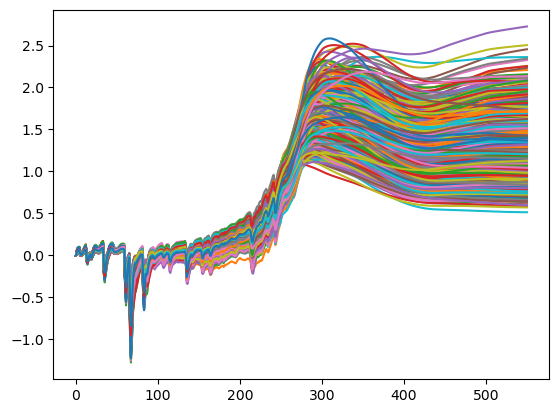

In [12]:
pl.plot(f.temperature[:, 0, :, 0]);

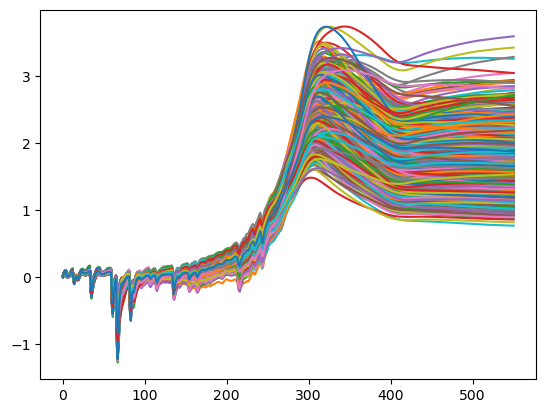

In [13]:
pl.plot(f.temperature[:, 1, :, 0]);

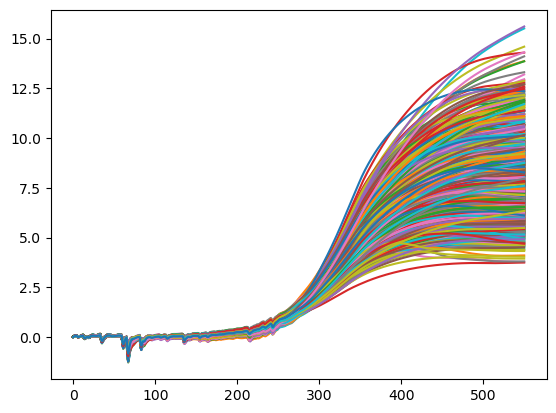

In [14]:
pl.plot(f.temperature[:, 2, :, 0]);

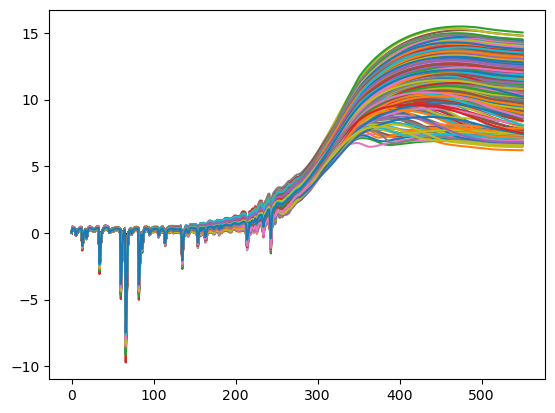

In [15]:
pl.plot(f.forcing_sum[:, 2, :]);

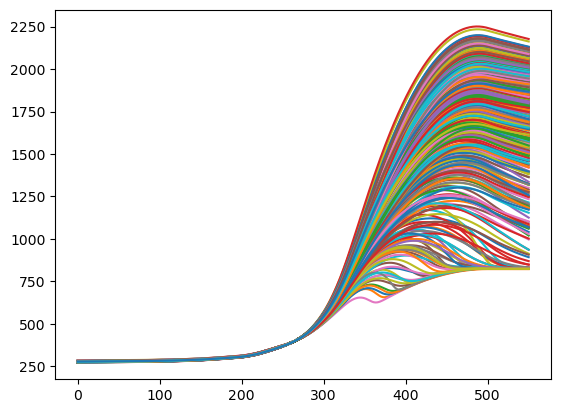

In [19]:
pl.plot(f.concentration[:, 2, :, 2]);

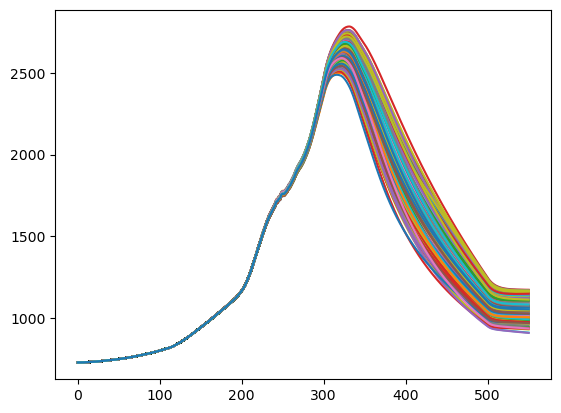

In [20]:
pl.plot(f.concentration[:, 2, :, 3]);

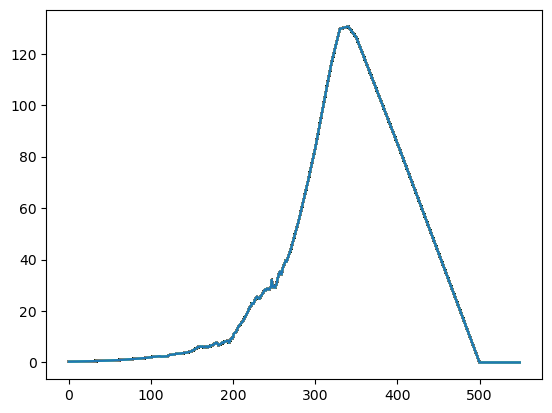

In [21]:
pl.plot(f.emissions[:, 2, :, 2]);

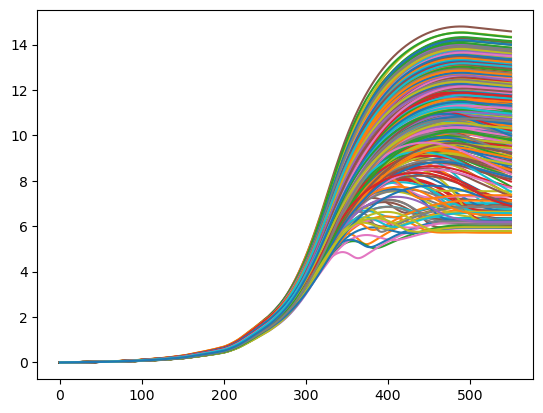

In [25]:
pl.plot(f.forcing[:, 2, :, 2]);

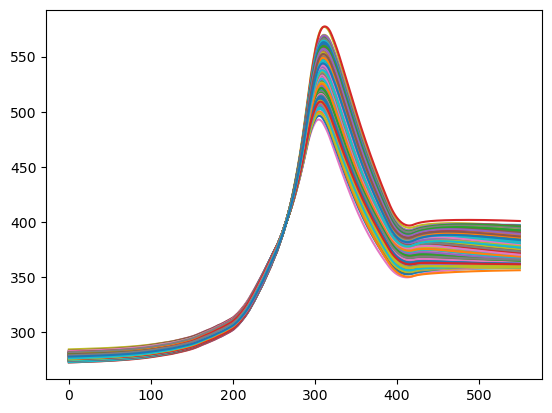

In [26]:
pl.plot(f.concentration[:, 1, :, 2]);

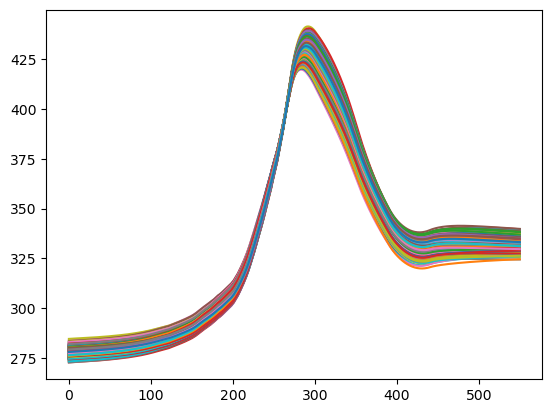

In [27]:
pl.plot(f.concentration[:, 0, :, 2]);

In [28]:
ds = xr.Dataset(
    data_vars = dict(
        temperature = (["timebound", "scenario", "config"], f.temperature[:, :, :, 0].data),
        forcing = (["timebound", "scenario", "config"], f.forcing_sum.data),
    ),
    coords = dict(
        timebound=np.arange(1750, 2301),
        scenario=scenarios,
        config=valid_all
    )
)

In [23]:
os.makedirs('../results', exist_ok=True)

In [29]:
ds.to_netcdf('../results/emis.nc')